In [1]:
import urllib

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers
AUTOTUNE = tf.data.experimental.AUTOTUNE

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)

import numpy as np

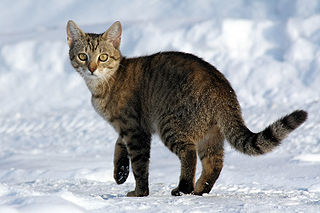

In [2]:
image_path = tf.keras.utils.get_file("cat.jpg", "https://storage.googleapis.com/download.tensorflow.org/example_images/320px-Felis_catus-cat_on_snow.jpg")

PIL.Image.open(image_path)


In [3]:
image_string = tf.io.read_file(image_path)
print(image_string)

image = tf.io.decode_jpeg(image_string, channels=3)
print(image)

tf.Tensor(b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\x00C\x00\x06\x04\x05\x06\x05\x04\x06\x06\x05\x06\x07\x07\x06\x08\n\x10\n\n\t\t\n\x14\x0e\x0f\x0c\x10\x17\x14\x18\x18\x17\x14\x16\x16\x1a\x1d%\x1f\x1a\x1b#\x1c\x16\x16 , #&\')*)\x19\x1f-0-(0%()(\xff\xdb\x00C\x01\x07\x07\x07\n\x08\n\x13\n\n\x13(\x1a\x16\x1a((((((((((((((((((((((((((((((((((((((((((((((((((\xff\xc0\x00\x11\x08\x00\xd5\x01@\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x04\x02\x05\x01\x06\x07\x08\x00\xff\xc4\x00?\x10\x00\x02\x01\x03\x03\x02\x05\x01\x05\x06\x05\x02\x06\x03\x00\x00\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13"Qaq\x07\x142\x81\x91\x08#B\xa1\xb1\xf0\x15R\xc1\xd1\xf1b\xe1\x16$3Cr\x824S\xb2\xff\xc4\x00\x1a\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\xff\xc4\x00\'\x11\x00\x02\x02\x02\x02\x02\x02\x03\x01\x01\x00\x03\x00\x00\x00\x00\x00\x01\x02\x11!1\x03

In [4]:
def visualise(original, augmented):
    fig = plt.figure()
    
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original)
    
    plt.subplot(1, 2, 2)
    plt.title("Augmented Image")
    plt.imshow(augmented)

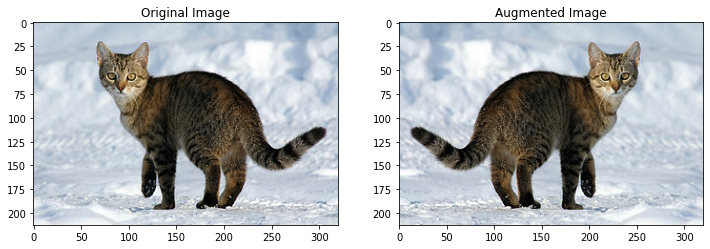

In [5]:
flipped = tf.image.flip_left_right(image)
visualise(image, flipped)

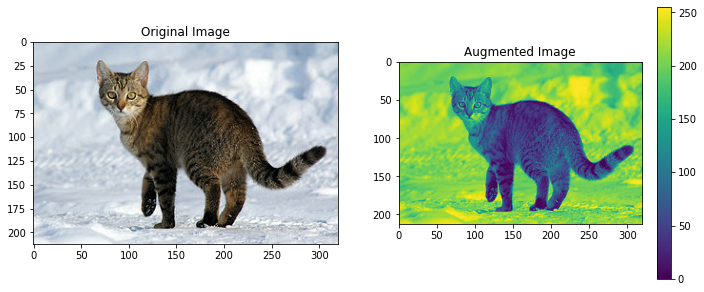

In [6]:
grey = tf.image.rgb_to_grayscale(image)
visualise(image, tf.squeeze(grey))
plt.colorbar()

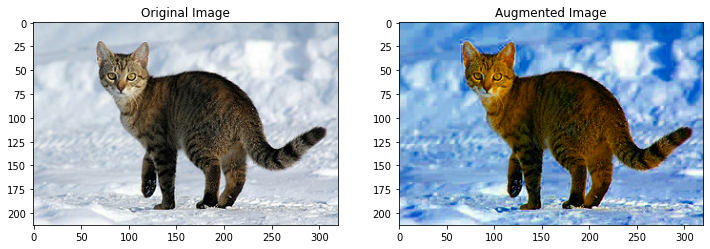

In [7]:
saturated = tf.image.adjust_saturation(image, 5)
visualise(image, saturated)

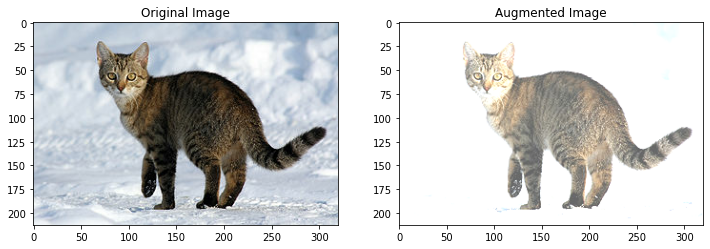

In [8]:
bright = tf.image.adjust_brightness(image, 0.4)
visualise(image, bright)

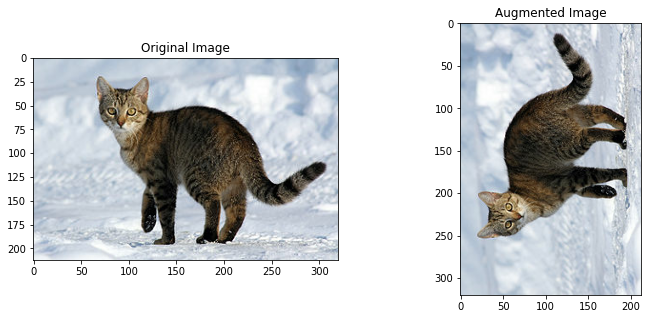

In [9]:
rotated = tf.image.rot90(image)
visualise(image, rotated)


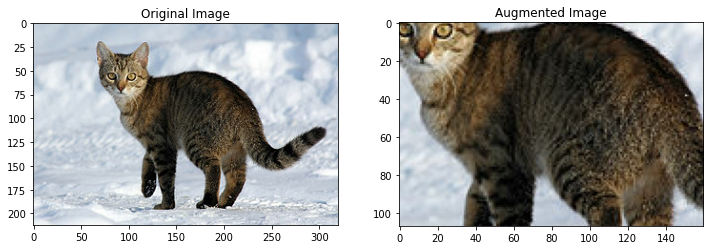

In [10]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualise(image, cropped)


In [11]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  return image, label


In [12]:
def augment(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_crop_or_pad(image, 34, 34)
    image = tf.image.random_crop(image, size=[28, 28, 1])
    image = tf.image.random_brightness(image, max_delta=0.5)
    return image,label
    
    

In [13]:
BATCH_SIZE = 64
# Only use a subset of the data so it's easier to overfit, for this tutorial
NUM_EXAMPLES = 100


In [14]:
dataset, info =  tfds.load('mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

num_train_examples= info.splits['train'].num_examples

In [15]:
augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # The augmentation is added here.
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 


In [16]:
non_augmented_train_batches = (
    train_dataset
    # Only train on a subset, so you can quickly see the effect.
    .take(NUM_EXAMPLES)
    .cache()
    .shuffle(num_train_examples//4)
    # No augmentation.
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
) 

In [17]:
validation_batches = (
    test_dataset
    .map(convert, num_parallel_calls=AUTOTUNE)
    .batch(2*BATCH_SIZE)
)



In [18]:
def make_model():
  model = tf.keras.Sequential([
      layers.Flatten(input_shape=(num_train_examples, 28, 28, 1)),
      layers.Dense(4096, activation='relu'),
      layers.Dense(4096, activation='relu'),
      layers.Dense(10)
  ])
  model.compile(optimizer = 'adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [ ]:
model_without_aug = make_model()

no_aug_history = model_without_aug.fit(non_augmented_train_batches, epochs=50, validation_data=validation_batches)


In [ ]:
model_with_aug = make_model()

aug_history = model_with_aug.fit(augmented_train_batches, epochs=50, validation_data=validation_batches)
